c:\Users\김소연\ToneDetect\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 [화자별 예측 결과 요약]

🧑 이효진
- formal(격식있는 말투): 52 문장 (59.09%)
- chat_emoticon(이모티콘 자주 쓰는 말투): 29 문장 (32.95%)
- soft_polite(부드럽고 상냥한 말투): 7 문장 (7.95%)

🧑 백진주
- formal(격식있는 말투): 50 문장 (56.18%)
- soft_polite(부드럽고 상냥한 말투): 39 문장 (43.82%)


C:\Users\김소연\AppData\Local\Temp\ipykernel_1156\315800301.py:94: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\김소연\ToneDetect\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


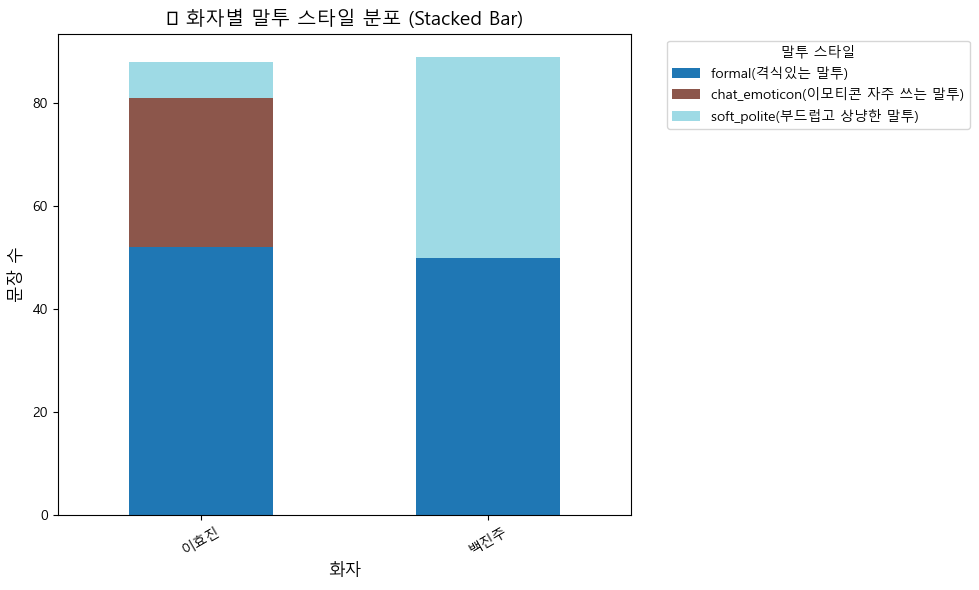

In [1]:
# ✅ 1. 기본 import
import sys
import os
import importlib
import torch
sys.path.append(os.path.join(os.getcwd(), "전처리"))
import merge
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel
from collections import defaultdict

plt.rcParams['font.family'] = 'Malgun Gothic'

# ✅ 2. merge.py 실행

import merge  # 전처리 모듈 불러오기

# ✅ 카톡 파일 지정 (변경 가능)
input_chat_path = "uploads/KakaoTalk_Test_.txt"

# ✅ merge 실행 → 정제된 문장 리스트 반환
clean_sentences = merge.run_merge(input_chat_path)  # run_merge() 함수가 merge.py에 있다고 가정

# ✅ 3. 모델 로드
ADAPTER_PATH = "Models/ToneDetect_adapter"
BASE_MODEL_NAME = "beomi/kcbert-base"  # 원래 학습할 때 사용한 베이스

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
base_model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_NAME, num_labels=5)
model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)
model.eval()

# ✅ 4. 예측 함수
def predict_style(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_class = torch.argmax(logits, dim=1).item()
    return pred_class

# ✅ 5. 라벨 정의
label_map = {
    0: "chat_emoticon(이모티콘 자주 쓰는 말투)",
    1: "elder_speech(어르신 말투)",
    2: "formal(격식있는 말투)",
    3: "informal(친근한 말투)",
    4: "soft_polite(부드럽고 상냥한 말투)"
}

# ✅ speaker 별 style_counts 초기화
speaker_style_counts = defaultdict(lambda: defaultdict(int))
clean_sentences = merge.run_merge(input_chat_path)

# ✅ 각 문장 예측
for msg in clean_sentences:
    speaker = msg['speaker']
    text = msg['text']
    pred = predict_style(text)
    style_name = label_map[pred]
    speaker_style_counts[speaker][style_name] += 1

# ✅ 결과 출력
print("\n📊 [화자별 예측 결과 요약]")
for speaker, style_counts in speaker_style_counts.items():
    print(f"\n🧑 {speaker}")
    total = sum(style_counts.values())
    for style, count in style_counts.items():
        percent = count / total * 100
        print(f"- {style}: {count} 문장 ({percent:.2f}%)")

# ✅ 8. 시각화 (화자별 stacked bar chart 예시)
import pandas as pd

# DataFrame으로 변환
data = []
for speaker, style_counts in speaker_style_counts.items():
    row = {'speaker': speaker}
    row.update(style_counts)
    data.append(row)

df = pd.DataFrame(data).fillna(0)
df.set_index('speaker', inplace=True)

# 시각화
df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title("📊 화자별 말투 스타일 분포 (Stacked Bar)", fontsize=14)
plt.xlabel("화자", fontsize=12)
plt.ylabel("문장 수", fontsize=12)
plt.xticks(rotation=30)
plt.legend(title='말투 스타일', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [2]:
from pprint import pprint

pprint(clean_sentences)

[{'order': 0,
  'speaker': '이효진',
  'text': '안녕하세요~ 진주님, 오늘 일정 괜찮으세요? ☺️',
  'timestamp': datetime.datetime(2025, 5, 29, 9, 10)},
 {'order': 1,
  'speaker': '백진주',
  'text': '네, 안녕하세요. 일정 확인하였습니다.',
  'timestamp': datetime.datetime(2025, 5, 29, 9, 12)},
 {'order': 2,
  'speaker': '이효진',
  'text': '오늘 정말 날씨가 좋아요~ 기분 좋은 하루가 될 것 같아요 ☀️',
  'timestamp': datetime.datetime(2025, 5, 29, 9, 13)},
 {'order': 3,
  'speaker': '백진주',
  'text': '네, 외출하기 좋은 날씨입니다.',
  'timestamp': datetime.datetime(2025, 5, 29, 9, 14)},
 {'order': 4,
  'speaker': '이효진',
  'text': '혹시 미팅 장소는 그대로인가요~?',
  'timestamp': datetime.datetime(2025, 5, 29, 9, 16)},
 {'order': 5,
  'speaker': '백진주',
  'text': '네, 변경 사항 없습니다. 약속드린 장소로 오시면 됩니다.',
  'timestamp': datetime.datetime(2025, 5, 29, 9, 17)},
 {'order': 6,
  'speaker': '이효진',
  'text': '알겠어요~ 시간 맞춰 갈게요 🎵',
  'timestamp': datetime.datetime(2025, 5, 29, 9, 18)},
 {'order': 7,
  'speaker': '백진주',
  'text': '네, 알겠습니다.',
  'timestamp': datetime.datetime(2025, 5, 29, 9, 19)},


In [3]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "전처리"))  # chat.py가 전처리 폴더에 있을 때
from chat import full_preprocess

# ✅ clean_sentences는 이미 다음 구조로 존재한다고 가정
# clean_sentences = [{"speaker": ..., "text": ..., "timestamp": ..., "order": ...}, ...]

for item in clean_sentences:
    text = item["text"]
    result = full_preprocess(text)

    item["cleaned"] = result["step3_no_emoticons"]
    item["emotion_chunks"] = result["emotion_chunks"]
    item["extracted_emoticons"] = result["extracted_emoticons"]

print("✅ 전처리 완료: 'cleaned', 'emotion_chunks', 'extracted_emoticons' 필드가 추가됨")

✅ 전처리 완료: 'cleaned', 'emotion_chunks', 'extracted_emoticons' 필드가 추가됨


In [4]:
from pprint import pprint

pprint(clean_sentences)

[{'cleaned': '안녕하세요 진주님, 오늘 일정 괜찮으세요?',
  'emotion_chunks': {'[여운]': ['~']},
  'extracted_emoticons': ['☺️'],
  'order': 0,
  'speaker': '이효진',
  'text': '안녕하세요~ 진주님, 오늘 일정 괜찮으세요? ☺️',
  'timestamp': datetime.datetime(2025, 5, 29, 9, 10)},
 {'cleaned': '네, 안녕하세요. 일정 확인하였습니다.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 1,
  'speaker': '백진주',
  'text': '네, 안녕하세요. 일정 확인하였습니다.',
  'timestamp': datetime.datetime(2025, 5, 29, 9, 12)},
 {'cleaned': '오늘 정말 날씨가 좋아요 기분 좋은 하루가 될 것 같아요',
  'emotion_chunks': {'[여운]': ['~']},
  'extracted_emoticons': ['☀️'],
  'order': 2,
  'speaker': '이효진',
  'text': '오늘 정말 날씨가 좋아요~ 기분 좋은 하루가 될 것 같아요 ☀️',
  'timestamp': datetime.datetime(2025, 5, 29, 9, 13)},
 {'cleaned': '네, 외출하기 좋은 날씨입니다.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 3,
  'speaker': '백진주',
  'text': '네, 외출하기 좋은 날씨입니다.',
  'timestamp': datetime.datetime(2025, 5, 29, 9, 14)},
 {'cleaned': '혹시 미팅 장소는 그대로인가요?',
  'emotion_chunks': {'[여운][의문]': ['~?']},
  'ext

In [ ]:
from collections import defaultdict, Counter

# 🔹 화자별 감정 문자열 / 이모티콘 카운터 및 예시 저장
speaker_emotion_counter = defaultdict(Counter)
speaker_emotion_examples = defaultdict(lambda: defaultdict(list))

speaker_emo_counter = defaultdict(Counter)
speaker_emo_examples = defaultdict(lambda: defaultdict(list))

for item in clean_sentences:
    speaker = item["speaker"]
    text = item["text"]

    # ✅ 감정 문자열 처리
    already_added_chunks = set()
    for chunk_list in item.get("emotion_chunks", {}).values():
        for chunk in chunk_list:
            speaker_emotion_counter[speaker][chunk] += 1
            if chunk not in already_added_chunks:
                if len(speaker_emotion_examples[speaker][chunk]) < 3 and text not in speaker_emotion_examples[speaker][chunk]:
                    speaker_emotion_examples[speaker][chunk].append(text)
                already_added_chunks.add(chunk)

    # ✅ 이모티콘 처리
    already_added_emoticons = set()
    for emo in item.get("extracted_emoticons", []):
        speaker_emo_counter[speaker][emo] += 1
        if emo not in already_added_emoticons:
            if len(speaker_emo_examples[speaker][emo]) < 3 and text not in speaker_emo_examples[speaker][emo]:
                speaker_emo_examples[speaker][emo].append(text)
            already_added_emoticons.add(emo)

# 🔹 출력
for speaker in sorted(set(speaker_emotion_counter) | set(speaker_emo_counter)):
    print(f"\n🗣️ 화자: {speaker}")

    top_chunks = speaker_emotion_counter[speaker].most_common(3)
    top_emoticons = speaker_emo_counter[speaker].most_common(3)

    # ✅ 감정 문자열 있을 때만 출력
    if top_chunks:
        print("  🔸 가장 많이 쓴 감정 표현 문자열 (emotion_chunks):")
        for chunk, count in top_chunks:
            print(f"    - {chunk}: {count}회")
            for example in speaker_emotion_examples[speaker][chunk]:
                print(f"        예시: {example}")

    # ✅ 이모티콘 있을 때만 출력
    if top_emoticons:
        print("  🔸 가장 많이 쓴 이모티콘 (extracted_emoticons):")
        for emo, count in top_emoticons:
            print(f"    - {emo}: {count}회")
            for example in speaker_emo_examples[speaker][emo]:
                print(f"        예시: {example}")



🗣️ 화자: 이효진
  🔸 가장 많이 쓴 감정 표현 문자열 (emotion_chunks):
    - ~: 71회
        예시: 안녕하세요~ 진주님, 오늘 일정 괜찮으세요? ☺️
        예시: 오늘 정말 날씨가 좋아요~ 기분 좋은 하루가 될 것 같아요 ☀️
        예시: 알겠어요~ 시간 맞춰 갈게요 🎵
    - ~?: 22회
        예시: 혹시 미팅 장소는 그대로인가요~?
        예시: 준비물은 따로 없을까요~?
        예시: 오늘 아침은 드셨어요~?
    - !: 4회
        예시: 오늘 회의 정말 유익했어요! 감사해요 ☺️
        예시: 다음에도 또 뵈어요~ 😊 좋은 하루 보내세요!
        예시: 오늘 발표 잘 해봐요~ 우리 화이팅이에요! 💪
  🔸 가장 많이 쓴 이모티콘 (extracted_emoticons):
    - 😊: 6회
        예시: 넵~ 챙겨가겠습니다 😊
        예시: 다음에도 또 뵈어요~ 😊 좋은 하루 보내세요!
        예시: 발표 자료 USB에 백업도 해둘게요~ 혹시 모를 상황 대비해서요 😊
    - ☺️: 5회
        예시: 안녕하세요~ 진주님, 오늘 일정 괜찮으세요? ☺️
        예시: 오늘 회의 정말 유익했어요! 감사해요 ☺️
        예시: 좋아요~ 잠깐 다녀오면 기분도 좋아질 거예요~ ☺️
    - 🥰: 5회
        예시: 좋아요~ 기대되네요 🥰
        예시: 진짜 감사해요~ 든든한 점심 기대돼요 🥰
        예시: 와~ 기대돼요~! 🥰


In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# ✅ 모델 & 토크나이저 불러오기
MODEL_PATH = "Models/pko-t5-finetuned"  # 너가 학습한 경로
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ✅ 정제 함수 정의
def refine_with_model(text: str) -> str:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=64)  # 필요시 길이 조정
    refined = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return refined.strip()

In [7]:
for item in clean_sentences:
    cleaned_text = item.get("cleaned", "")
    if cleaned_text:
        try:
            item["refined"] = refine_with_model(cleaned_text)
        except Exception as e:
            print(f"❗ '{cleaned_text}' 정제 중 오류 발생:", e)
            item["refined"] = ""  # 실패 시 빈 문자열로 표시

print("✅ 모든 cleaned 문장에 대해 refined 결과 추가 완료")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


✅ 모든 cleaned 문장에 대해 refined 결과 추가 완료


In [8]:
from pprint import pprint

pprint(clean_sentences)

[{'cleaned': '안녕하세요 진주님, 오늘 일정 괜찮으세요?',
  'emotion_chunks': {'[여운]': ['~']},
  'extracted_emoticons': ['☺️'],
  'order': 0,
  'refined': '안녕하세요? 사장님, 오늘 일정 괜찮으세요?',
  'speaker': '이효진',
  'text': '안녕하세요~ 진주님, 오늘 일정 괜찮으세요? ☺️',
  'timestamp': datetime.datetime(2025, 5, 29, 9, 10)},
 {'cleaned': '네, 안녕하세요. 일정 확인하였습니다.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 1,
  'refined': '네, 안녕하세요? 일정 확인하였습니다.',
  'speaker': '백진주',
  'text': '네, 안녕하세요. 일정 확인하였습니다.',
  'timestamp': datetime.datetime(2025, 5, 29, 9, 12)},
 {'cleaned': '오늘 정말 날씨가 좋아요 기분 좋은 하루가 될 것 같아요',
  'emotion_chunks': {'[여운]': ['~']},
  'extracted_emoticons': ['☀️'],
  'order': 2,
  'refined': '오늘 정말 날씨가 안 좋아요. 오늘 정말 날씨가 안 좋은 것 같아요.',
  'speaker': '이효진',
  'text': '오늘 정말 날씨가 좋아요~ 기분 좋은 하루가 될 것 같아요 ☀️',
  'timestamp': datetime.datetime(2025, 5, 29, 9, 13)},
 {'cleaned': '네, 외출하기 좋은 날씨입니다.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 3,
  'refined': '네, 요즘 날씨에 맞지 않는 옷차림입니다.',
  'speaker': '